## Explore the provided sample training data

## Load training set metadata (driving_log.csv)

In [77]:
# Note using dlnd-tf-lab environment
# Tensorflow == 1.3.0
# Keras == 1.0.7
# Modified convolution.py to include cropping layer
import cv2
import csv
import numpy as np
import os
import pandas as pd
import keras
import zipfile
# Check that all the layers the model need is available
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout, BatchNormalization

log_cols = ['center', 'left', 'right', 'steer', 'throttle', 'brake', 'speed']
lap_log_df = pd.read_csv(
    '../lap2/driving_log.csv', 
    header=None, 
)
lap_log_df.columns=log_cols

## Visualize input images

Populating the interactive namespace from numpy and matplotlib


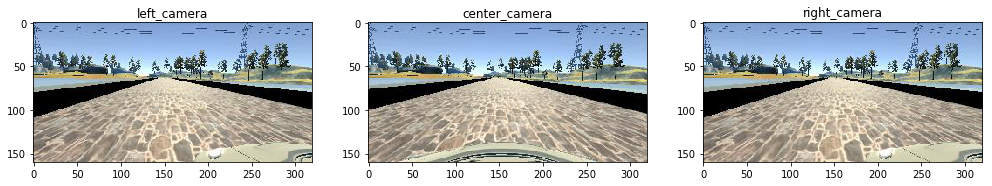

In [2]:
% pylab inline
import matplotlib.pyplot as plt
def load_and_cvtColor(img_file, zip_handle=None): 
    if zip_handle: 
        data = zip_handle.read(img_file)
        decoded = cv2.imdecode(np.frombuffer(data, np.uint8), 1) 
        return cv2.cvtColor(decoded, cv2.COLOR_BGR2RGB)
    else: 
        return cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)

def view_frame(center_file, zip_handle=None):
    left_file = center_file.replace('center', 'left')
    right_file = center_file.replace('center', 'right')
    fig, axes = plt.subplots(1, 3, figsize=(17, 5))

    center_image = load_and_cvtColor(center_file, zip_handle=zip_handle)
    left_image = load_and_cvtColor(left_file, zip_handle=zip_handle)
    right_image = load_and_cvtColor(left_file, zip_handle=zip_handle)
        
    axes[0].imshow(left_image, interpolation='nearest')    
    axes[0].set_title('left_camera')
    axes[1].imshow(center_image, interpolation='nearest')
    axes[1].set_title('center_camera')
    axes[2].imshow(right_image, interpolation='nearest')
    axes[2].set_title('right_camera')

# Visualize my first_track generated data
randix = np.random.randint(size=1, low=0, high=len(lap_log_df))[0]
view_frame(lap_log_df.ix[randix]['center'])

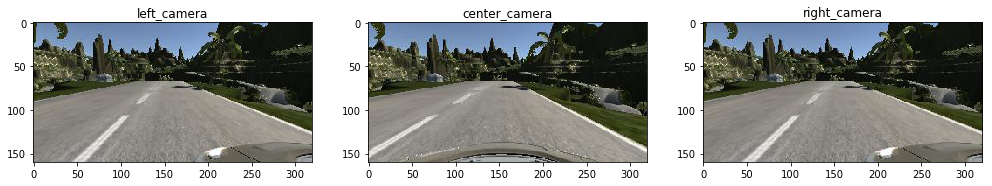

In [79]:
# Visualize my second_track generated data
track2_log_df = pd.read_csv(
    '../track2_lap1/driving_log.csv', 
    header=None, 
)
track2_log_df.columns=log_cols

# Visualize my first_track generated data
randix = np.random.randint(size=1, low=0, high=len(lap_log_df))[0]
view_frame(track2_log_df.ix[randix]['center'])

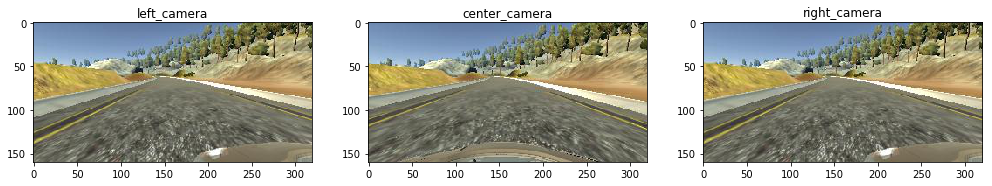

In [71]:
# Visualize provided data
provided_path_prefix = '../provided_data'
provided_log_df = pd.read_csv(os.path.join(provided_path_prefix, 'driving_log.csv'))
provided_log_df.columns = log_cols
for col in ['center', 'left', 'right']: 
    provided_log_df[col] = provided_log_df[col].apply(lambda x: os.path.join(provided_path_prefix, x.strip()))
    
randix = np.random.randint(size=1, low=0, high=len(provided_log_df))[0]
view_frame(provided_log_df.ix[randix]['center'])

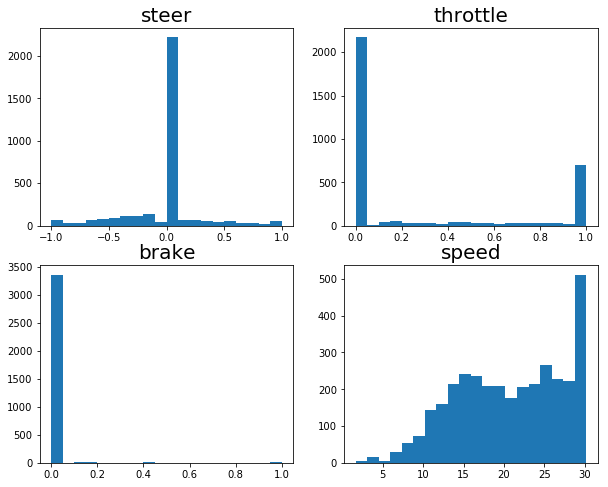

In [19]:
def hist_measurements(log_df, steer_col='steer'):
    fontsize = 20
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes[0][0].hist(log_df[steer_col], bins=20)
    axes[0][0].set_title(steer_col, fontsize=fontsize)
    axes[0][1].hist(log_df['throttle'], bins=20)
    axes[0][1].set_title('throttle', fontsize=fontsize)
    axes[1][0].hist(log_df['brake'], bins=20)
    axes[1][0].set_title('brake', fontsize=fontsize)
    axes[1][1].hist(log_df['speed'], bins=20)
    axes[1][1].set_title('speed', fontsize=fontsize)
    
hist_measurements(lap_log_df)

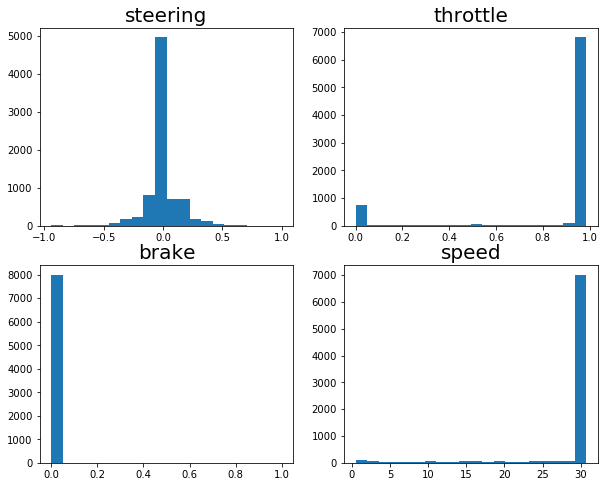

In [20]:
hist_measurements(provided_log_df, steer_col='steering')

In [7]:
# Experiment with augmentation
def flip_image(img):
    return np.fliplr(img)


def flip_image_rgb(img):
    return flip_image(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

def adjust_angle_per_camera(features, camera):
    """ create adjusted steering measurements for the side camera images
    """
    correction = 0.25
    if camera == 'left':
        features[0] = features[0] + correction
    elif camera == 'right':
        features[0] = features[0] - correction
    return features


def adjust_properties_per_transform(features, camera, transform):
    """ create adjusted steering measurements for the specific transform
    """
    # Flipping - Take the opposite sign and invert left/right cameras
    if 'flip' in transform.__name__:
        features[0] = features[0] * - 1
        if camera == 'right':
            camera = 'left'
        elif camera == 'left':
            camera = 'right'
    return features, camera

## Create Model Layers

In [63]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Cropping2D, Lambda, merge, BatchNormalization, Input
from keras.layers.core import Dense, Activation, Flatten, Dropout, Reshape
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D, ZeroPadding2D
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import json
import cv2
import os
# Fix error with TF and Keras
import tensorflow as tf
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt


# def driveLogGeneratorFromZip(zip_filename, batch_size=10, start_idx=0, max_batch=10000):
#     batch_counter = 0
#     with open(zip_filename)
#     while batch_counter < max_batch: 
#         start_idx = start_idx if start_idx < len(log_df) else start_idx - len(log_df)
#         end_idx = min(len(log_df), start_idx + batch_size - 1)
#         batch_images = []
#         steers = []
#         steer_col = [c for c in log_df if 'steer' in c][0]
#         for idx, row in log_df.ix[start_idx:end_idx].iterrows():
#             print("steer_col", steer_col, row[steer_col], row['center'])
#             im_center = load_and_cvtColor(row['center'])
#             im_left = load_and_cvtColor(row['left'])
#             im_right = load_and_cvtColor(row['right'])
#             batch_images.append(im_center)
#             steers.append(row[steer_col])

#         start_idx += batch_size
#         batch_counter += 1
#         yield np.array(batch_images), steers
        

def driveLogGenerator(log_df, batch_size=10, start_idx=0, max_batch=10000, correction=0.25, with_flip=True):
    batch_counter = 0
    while batch_counter < max_batch: 
        start_idx = start_idx if start_idx < len(log_df) else start_idx - len(log_df)
        end_idx = min(len(log_df), start_idx + batch_size - 1)
        batch_images = []
        steers = []
        steer_col = [c for c in log_df if 'steer' in c][0]
        if with_flip: 
            for idx, row in log_df.ix[start_idx:end_idx].iterrows():
                im_center = load_and_cvtColor(row['center'])
                im_left = load_and_cvtColor(row['left'])
                im_right = load_and_cvtColor(row['right'])
                batch_images.extend([
                    im_center, im_left, im_right, 
                    np.fliplr(im_center), np.fliplr(im_left), np.fliplr(im_right)
                ])
                steers.extend([
                    row[steer_col], row[steer_col]+correction, row[steer_col]-correction, 
                    row[steer_col], row[steer_col]-correction, row[steer_col]+correction              
                ])

            start_idx += batch_size
            batch_counter += 1
            yield np.array(batch_images), steers
        else: 
            for idx, row in log_df.ix[start_idx:end_idx].iterrows():
                im_center = load_and_cvtColor(row['center'])
                im_left = load_and_cvtColor(row['left'])
                im_right = load_and_cvtColor(row['right'])
                batch_images.extend([
                    im_center, im_left, im_right
                ])
                steers.extend([
                    row[steer_col], row[steer_col]+correction, row[steer_col]-correction           
                ])

            start_idx += batch_size
            batch_counter += 1
            yield np.array(batch_images), steers


def conv2d_bn(input_x, filters, rows, cols, border_mode='same', strides=(1, 1)):
    """ Combine Convolution2D and BatchNormalization
    """
    input_x = Convolution2D(filters, rows, cols,
                            subsample=strides,
                            activation='elu',
                            border_mode=border_mode)(input_x)
    input_x = BatchNormalization()(input_x)
    return input_x 

def smallModel(ch=3, row=160, col=320):
    img_input = Input(shape=(row, col, ch))
    x = Lambda(lambda x: x / 255.0 - 0.5)(img_input)
    x = Cropping2D(cropping=((70, 25), (0, 0)))(x)
    x = conv2d_bn(x, 24, 5, 5, strides=(2, 2))
    x = conv2d_bn(x, 36, 5, 5, strides=(2, 2))
    x = conv2d_bn(x, 64, 3, 3)
    x = Flatten(name='flatten')(x)
    x = Dropout(0.5)(x)
    x = Dense(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(10)(x)
    x = Dense(1)(x)
    return Model(img_input, x)

def model(ch=3, row=160, col=320):
    img_input = Input(shape=(row, col, ch))
    x = Lambda(lambda x: x / 255.0 - 0.5)(img_input)
    x = Cropping2D(cropping=((70, 25), (0, 0)))(x)
    x = conv2d_bn(x, 24, 5, 5, strides=(2, 2))
    x = conv2d_bn(x, 36, 5, 5, strides=(2, 2))
    x = conv2d_bn(x, 64, 5, 5, strides=(2, 2))
    x = conv2d_bn(x, 256, 3, 3)
    x = Flatten(name='flatten')(x)
    x = Dropout(0.5)(x)
    x = Dense(100)(x)
    x = Dense(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(10)(x)
    x = Dense(1)(x)
    return Model(img_input, x)

In [37]:
sm = smallModel()
sm.compile(optimizer='adam', loss='mse')
sm.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
lambda_11 (Lambda)               (None, 160, 320, 3)   0           input_3[0][0]                    
____________________________________________________________________________________________________
cropping2d_3 (Cropping2D)        (None, 160, 225, 3)   0           lambda_11[0][0]                  
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 24, 113, 2)    96024       cropping2d_3[0][0]               
___________________________________________________________________________________________

In [50]:
nv = nvidiaModel()
nv.compile(optimizer='adam', loss='mse')
nv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_5 (InputLayer)             (None, 160, 320, 3)   0                                            
____________________________________________________________________________________________________
lambda_17 (Lambda)               (None, 160, 320, 3)   0           input_5[0][0]                    
____________________________________________________________________________________________________
cropping2d_5 (Cropping2D)        (None, 160, 225, 3)   0           lambda_17[0][0]                  
____________________________________________________________________________________________________
convolution2d_26 (Convolution2D) (None, 24, 113, 2)    96024       cropping2d_5[0][0]               
___________________________________________________________________________________________

## Try training model on few images

In [64]:
# Training with my own generated data
SAMPLES_PER_EPOCH = 512
EPOCHS = 50
sm.fit_generator(
    driveLogGenerator(lap_log_df, batch_size=128), 
    samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
    callbacks=[], validation_data=driveLogGenerator(lap_log_df), nb_val_samples=100, nb_worker=1
)

import os
model_output_path = os.path.normpath('../model')
if not os.path.isdir(model_output_path):
    os.makedirs(model_output_path)
    
sm.save(os.path.join(model_output_path, 'small_model.h5'))

Epoch 1/50


/Users/trimchala/miniconda/envs/aind-dog/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


768/512 [=============================================] - 6s - loss: 57.3070 - val_loss: 0.7497
Epoch 2/50
768/512 [=============================================] - 5s - loss: 73.0088 - val_loss: 0.3055
Epoch 3/50
768/512 [=============================================] - 5s - loss: 137.3050 - val_loss: 0.4637
Epoch 4/50
768/512 [=============================================] - 5s - loss: 49.2272 - val_loss: 0.4195
Epoch 5/50
768/512 [=============================================] - 4s - loss: 27.3879 - val_loss: 0.2761
Epoch 6/50
768/512 [=============================================] - 5s - loss: 38.8983 - val_loss: 0.7463
Epoch 7/50
768/512 [=============================================] - 5s - loss: 123.6059 - val_loss: 0.9956
Epoch 8/50
768/512 [=============================================] - 5s - loss: 108.2132 - val_loss: 0.6697
Epoch 9/50
768/512 [=============================================] - 5s - loss: 20.2058 - val_loss: 1.6078
Epoch 10/50
768/512 [========================

In [ ]:
# Training with udacity provided data
SAMPLES_PER_EPOCH = 512
EPOCHS = 50

provided_path_prefix = '../provided_data'
provided_log_df = pd.read_csv(os.path.join(provided_path_prefix, 'driving_log.csv'))
provided_log_df.columns = log_cols
for col in ['center', 'left', 'right']: 
    provided_log_df[col] = provided_log_df[col].apply(
        lambda x: os.path.join(provided_path_prefix, x.strip()))

# Training with my own generated data
SAMPLES_PER_EPOCH = 512
EPOCHS = 50
sm.fit_generator(
    driveLogGenerator(provided_log_df, batch_size=128), 
    samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
    callbacks=[], validation_data=driveLogGenerator(provided_log_df), nb_val_samples=100, nb_worker=1
)

sm.fit_generator(
    driveLogGenerator(lap_log_df, batch_size=128), 
    samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
    callbacks=[], validation_data=driveLogGenerator(provided_log_df), nb_val_samples=100, nb_worker=1
)

import os
model_output_path = os.path.normpath('../model')
if not os.path.isdir(model_output_path):
    os.makedirs(model_output_path)
    
sm.save(os.path.join(model_output_path, 'small_model.h5'))

In [80]:
SAMPLES_PER_EPOCH = 512
EPOCHS = 100
batch_size = 128

## Train with first batch of generated data
# nv.fit_generator(
#     driveLogGenerator(lap_log_df, batch_size=batch_size), 
#     samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
#     callbacks=[], validation_data=driveLogGenerator(lap_log_df), nb_val_samples=100, nb_worker=1
# )
# import os
# model_output_path = os.path.normpath('../model')
# if not os.path.isdir(model_output_path):
#     os.makedirs(model_output_path)
# nv.save(os.path.join(model_output_path, 'nv_model.h5'))

## Train with provided data
# nv.fit_generator(
#     driveLogGenerator(provided_log_df, batch_size=batch_size), 
#     samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
#     callbacks=[], validation_data=driveLogGenerator(provided_log_df), nb_val_samples=100, nb_worker=1
# )
# nv.save(os.path.join(model_output_path, 'nv_model.h5'))

## Train with second track data
nv.fit_generator(
    driveLogGenerator(track2_log_df, batch_size=batch_size), 
    samples_per_epoch = SAMPLES_PER_EPOCH, nb_epoch = EPOCHS, verbose=1, 
    callbacks=[], validation_data=driveLogGenerator(track2_log_df), nb_val_samples=100, nb_worker=1
)
nv.save(os.path.join(model_output_path, 'nv_model.h5'))



Epoch 1/100


/Users/trimchala/miniconda/envs/aind-dog/lib/python3.5/site-packages/keras/engine/training.py:1573: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


768/512 [=============================================] - 7s - loss: 2.6617 - val_loss: 0.0800
Epoch 2/100
768/512 [=============================================] - 6s - loss: 3.5099 - val_loss: 0.0716
Epoch 3/100
768/512 [=============================================] - 6s - loss: 2.9218 - val_loss: 0.2113
Epoch 4/100
768/512 [=============================================] - 6s - loss: 3.7431 - val_loss: 0.7375
Epoch 5/100
768/512 [=============================================] - 6s - loss: 3.1624 - val_loss: 0.2902
Epoch 6/100
768/512 [=============================================] - 8s - loss: 3.3237 - val_loss: 0.4961
Epoch 7/100
768/512 [=============================================] - 7s - loss: 3.3224 - val_loss: 0.1582
Epoch 8/100
768/512 [=============================================] - 6s - loss: 3.0625 - val_loss: 0.1920
Epoch 9/100
768/512 [=============================================] - 6s - loss: 3.2431 - val_loss: 0.1127
Epoch 10/100
768/512 [===========================

In [60]:
im_center.shape

(160, 320, 3)

In [62]:
np.fliplr(im_center).shape

(160, 320, 3)